# this module will implement a 3D renderer for cubes
# ideally, code this so that it is not that hard to make it in verilog

In [1103]:
from IPython.display import display 
from PIL import Image

In [1104]:
# definitions

u = (1, 0, 0)
v = (0, 1, 0)
e = (1800, 1800, 0)
# w = 1024
# h = 768
w = int(1024/4)
h = int(768/4)

# these are sorted by distance
blocks_pos = [(1800, 1800, 700), (1900, 1800, 800), (1700, 1700, 800), (1700, 1900, 900)]
blocks_mat = [(1, 0, 0, 0.7), (0, 0, 1, 0.7), (1, 0.5, 0.5, 0.7), (1, 0.5, 0.5, 0.2)] # ranges from 0 to 1, diffuse RGB and reflection
lights_pos = [(1800, 1800, 100)]
lights_intense = [(1, 1, 1)] # colored lights

In [1105]:
# import image
img = Image.new("RGB", (w, h))

In [1106]:
# display image
def display_image():
    display(img)

In [1107]:
def zero_image():
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            img.putpixel((i, j), (0, 0, 0))

In [1108]:
# helper functions
def scale(v, c):
    return (v[0] * c, v[1] * c, v[2] * c)
def size(v):
    return dot(v, v)**0.5
def add(v1, v2):
    return (v1[0] + v2[0], v1[1] + v2[1], v1[2] + v2[2])
def sub(v1, v2):
    return (v1[0] - v2[0], v1[1] - v2[1], v1[2] - v2[2])
def dot(v1, v2):
    return (v1[0] * v2[0]) + (v1[1] * v2[1]) + (v1[2] * v2[2])

In [1109]:
def eye_to_pixel(x, y):
    # TODO: future, need to incorporate rotation into this algorithm
    # right now, it will follow the player, but it will never rotate
    proj_plane_top_left = (e[0] - w/2, e[1] - h/2, 200)
    proj_plane_point = add(add(scale(u, x), scale(v, y)), proj_plane_top_left)
    dir = sub(proj_plane_point, e)
    dir = scale(dir, 1/size(dir))
    return dir

# coords = [(0, 0), (w/2, h/2), (w, h)]
# for x, y in coords:
#     print(f"({x}, {y}) -> {eye_to_pixel(x, y)}")

In [1110]:
def does_ray_block_intersect(ray, block_pos, radius, block_mat, t):
    dist = sub(e, block_pos)
    a = dot(ray, ray)
    b = 2 * dot(ray, dist)
    c = dot(dist, dist) - (radius * radius)
    discr = (b * b) - (4 * a * c)

    if discr >= 0:
        sqrtdiscr = discr**0.5

        if b >= 0:
            sol1 = (-b - sqrtdiscr) / (2 * a)
            sol2 = (2 * c) / (-b - sqrtdiscr)
            new_t = min(sol1, sol2)
        else:
            sol1 = (2 * c) / (-b + sqrtdiscr)
            sol2 = (-b + sqrtdiscr) / (2 * a)
            new_t = min(sol1, sol2)
        
        if new_t > 0 and new_t < t[0]:
            # t represents the distance from the eye to the sphere
            t[0] = new_t
            return True
    
    return False

t = [10000000]
print(does_ray_block_intersect(eye_to_pixel(w/2, h/2), (1800, 1800, 200), 1, (1, 1, 1, 1), t))
print(f"t = {t}")

True
t = [199.0]


In [1111]:
def get_pixel_color(block_pos, block_mat, ray, t):
    newOrigin = add(e, scale(ray, t[0]))
    normal = sub(newOrigin, block_pos)
    normal_magnitude = size(normal)

    if normal == 0:
        return (0, 0, 0)
    
    normal = scale(normal, 1/normal_magnitude)

    r = 0.0
    g = 0.0
    b = 0.0
    for i in range(len(lights_pos)):
        light_pos = lights_pos[i]
        light_intense = lights_intense[i]
        dist = sub(light_pos, newOrigin)

        if dot(normal, dist) <= 0:
            continue
        
        rayDir = scale(dist, 1/size(dist))

        lambert = dot(rayDir, normal)

        r += (light_intense[0] * block_mat[0] * lambert)
        g += (light_intense[1] * block_mat[1] * lambert)
        b += (light_intense[2] * block_mat[2] * lambert)

    return r, g, b

def set_pixel_color(block_pos, block_mat, ray, x, y, t):
    r, g, b = get_pixel_color(block_pos, block_mat, ray, t)
    r = int(min(r, 1) * 255.0)
    g = int(min(g, 1) * 255.0)
    b = int(min(b, 1) * 255.0)
    # print(f"SET PIXEL {r}, {g}, {b}")
    img.putpixel((x, y), (r, g, b))

# print(get_pixel_color((1800, 1800, 200), (1, 0, 0, 0.5), eye_to_pixel(w/2, h/2), t))

In [1112]:
def render_frame():
    for y in range(h):
        for x in range(w):
            ray = eye_to_pixel(x, y)
            t = [1000000000]

            block = -1

            for i in range(len(blocks_pos)):
                if does_ray_block_intersect(ray, blocks_pos[i], 90, blocks_mat[i], t):
                    block = i
                    break
            
            if block == -1:
                img.putpixel((x, y), (0, 0, 0))
                continue

            set_pixel_color(blocks_pos[block], blocks_mat[block], ray, x, y, t)

In [1113]:
# function just needed for calculating uv
def cross(v1, v2):
    return (
        (v1[1] * v2[2]) - (v1[2] * v2[1]),
        (v1[2] * v2[0]) - (v1[0] * v2[2]),
        (v1[0] * v2[1]) - (v1[1] * v2[0])
    )

In [1114]:
# view_direction = (0, 0, 1)
# up = (0, -1, 0)
# wv = scale(view_direction, 1/size(view_direction))
# u = scale(cross(up, wv), 1/size(cross(up, wv)))
# v = cross(wv,u)
# print(f"u={u}, v={v}")

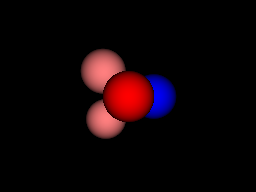

In [1115]:
zero_image()
render_frame()
display_image()

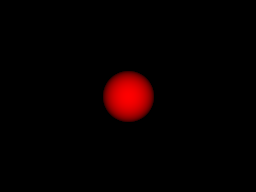

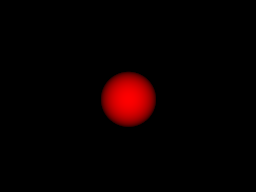

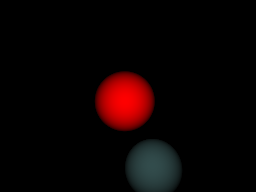

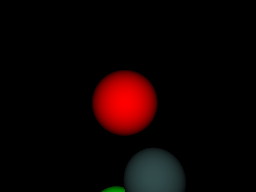

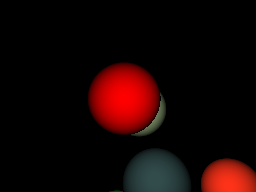

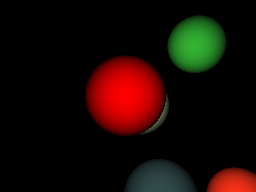

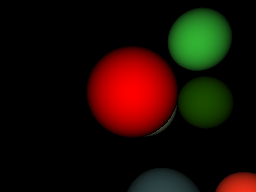

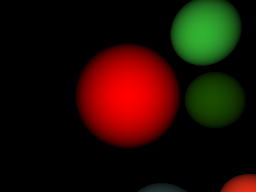

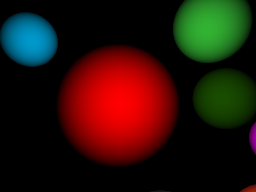

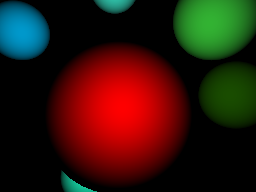

In [1130]:
import random
blocks_pos = [(1800, 1800, 700)]
blocks_mat = [(1, 0, 0, 0.7)]
for i in range(10):
    render_frame()
    display_image()
    
    for j in range(len(blocks_pos)):
        blocks_pos[j] = (blocks_pos[j][0] + random.randint(-16, 16), blocks_pos[j][1] + random.randint(-16, 16), blocks_pos[j][2] - 50)
    for j in range(random.randint(0, 10)):
        if random.randint(0, 1) == 0:
            blocks_pos.append((1800 + random.randint(-512, 512), 1800 + random.randint(-512, 512), blocks_pos[-1][2] + 32))
            blocks_mat.append((random.randint(0, 10) / 10, random.randint(0, 10) / 10, random.randint(0, 10) / 10, random.randint(0, 10) / 10))